In [1]:
''' compute (1) rotary sepctra and of wind stress and near-surface current velocity 
'''
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import math
import cftime
import sys
import re
from oceans.ocfis import spec_rot, spdir2uv
# from metpy import calc
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from windstr import ra_windstr_nc
from metpy.calc import wind_components, density, mixing_ratio_from_relative_humidity, wind_direction
from metpy.units import units
from convert_dir import vector_dir_to_from

In [31]:
##### compare wind data first #####
### buoy met data info
year = '2023'
buoy_id = '42022'
path_data = '/Users/chi/Documents/Data/NDBC/'
fn_met = 'met_ndbc'+buoy_id+'_y'+year+'.txt'
dtMet_adjust = datetime.timedelta(minutes=-5)
print('adjust "time" of buoy met data by',dtMet_adjust)
dtCur_adjust = datetime.timedelta(minutes=3)
print('adjust "time" of buoy current data by',dtCur_adjust)
### read met data
arrayMet = np.genfromtxt(path_data+fn_met,skip_header=2)
arrayMet[arrayMet== 999] = np.nan
### convert to datetime
dtime_met_buoy = []
for i in range( arrayMet.shape[0] ):
    dtime_met_buoy.append( datetime.datetime(int(arrayMet[i,0]),int(arrayMet[i,1]),int(arrayMet[i,2]),int(arrayMet[i,3]),int(arrayMet[i,4]))+dtMet_adjust )
dtime_met_buoy = np.array( dtime_met_buoy )
print('buoy wind time:',dtime_met_buoy[0:2],'...',dtime_met_buoy[-1])
### convert to u & v wind components
uwnd_buoy, vwnd_buoy = wind_components(arrayMet[:,6]*units('m/s'),arrayMet[:,5]*units.deg)
uwnd_buoy = np.array(uwnd_buoy)
vwnd_buoy = np.array(vwnd_buoy)

### SD-1042 merged nc file info
year = '2023'
platf_num = '1042'
path_airsea = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_airsea/'
tlim_plot = [datetime.datetime(int(year),10,17), datetime.datetime(int(year),11,16)] ### 2023 SD1042
nday_plot = (tlim_plot[1]-tlim_plot[0]).days
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nday_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]

### load airsea data
ds_airsea = nc.Dataset(path_airsea+'airsea-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_airsea.variables['time'][:]
dtime_met_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
uwnd_SD = ds_airsea.variables['UWND_MEAN'][:]
vwnd_SD = ds_airsea.variables['VWND_MEAN'][:]
print('airsea data time:',dtime_met_SD.shape, uwnd_SD.shape)
print('SD wind time:',dtime_met_SD[0:2],'...',dtime_met_SD[-1])

adjust "time" of buoy met data by -1 day, 23:55:00
adjust "time" of buoy current data by 0:03:00
buoy wind time: [datetime.datetime(2023, 1, 1, 0, 0) datetime.datetime(2023, 1, 1, 0, 30)] ... 2023-12-31 23:30:00
airsea data time: (44040,) (44040,)
SD wind time: [datetime.datetime(2023, 10, 17, 10, 0)
 datetime.datetime(2023, 10, 17, 10, 1)] ... 2023-11-16 23:59:00


In [3]:
##### Read current data #####
### buoy current data info
path_data = '/Users/chi/Documents/Data/NDBC/'
fn_cur = 'current_ndbc'+buoy_id+'_y'+year+'.txt'
### Read buoy current data
nline_header = 2 ### need to check lines of headers manually
with open(path_data+fn_cur, 'r') as f:
    nrow = len(f.readlines())
    print('Total Number of lines in the current data file:', nrow)
### get the headers & number of items in the header
count = 0
print('The caveat is that the file does not have exact same number of items in the header as in the data...')
with open(path_data+fn_cur, 'r') as f:
    for line in f:
        if count == nline_header:
            line_1 = re.sub(r"\s+",',',line) ### replace space(s) with ','
            if line_1[-1] == ',':
                line_1 = line_1[:-1]
            break
        count = count + 1
### read through the file
line_1_list = line_1.split(',')
ncol = len(line_1_list) # number of items in the first line of data
arrayCur = np.nan*np.ones( (nrow-nline_header,ncol) ) ### record values only
count = 0
with open(path_data+fn_cur) as f:
    for line in f:
        count = count + 1
        line_1 = re.sub(r"\s+",',',line)
        if line_1[-1] == ',':
                line_1 = line_1[:-1]
        # print(line_1)
        if count > nline_header:
            temp = line_1.split(',')
            temp = [float(item) for item in temp]
            nitem = len(temp)
            arrayCur[count-nline_header-1,0:nitem] = np.array(temp)
        
print('Shape of arrayCur:',arrayCur.shape)
arrayCur[arrayCur == 999] = np.nan

### convert to datetime
dtime_cur_buoy = []
for i in range( arrayCur.shape[0] ):
    dtime_cur_buoy.append( datetime.datetime(int(arrayCur[i,0]),int(arrayCur[i,1]),int(arrayCur[i,2]),int(arrayCur[i,3]),int(arrayCur[i,4]))+dtCur_adjust )
dtime_cur_buoy = np.array( dtime_cur_buoy )
print(dtime_cur_buoy[0:3],dtime_cur_buoy[-1])

### depths of current
depths_cur_buoy = arrayCur[0,5:-1:3]
print('Depths: The distance from the sea surface to the middle of the depth cells, or bins, measured in meters:', depths_cur_buoy)

### compute u & v current velocity from speed (cm/s) and direction (flowing toward) from the current data
ucur_buoy = np.nan*np.ones( (arrayCur.shape[0],len(depths_cur_buoy)) )
vcur_buoy = ucur_buoy.copy()
i0dep = 5
i0dir = 6
i0spd = 7
for i in range( ucur_buoy.shape[0] ): ### time dimension
    for z in range( len(depths_cur_buoy) ): ### depth dimension
        spd_item = arrayCur[i,i0spd+z*3]
        dir_to_item = arrayCur[i,i0dir+z*3] # direction flowing toward
        dir_from_item = (dir_to_item+180)%360
        ucur_buoy[i,z], vcur_buoy[i,z] = spdir2uv( spd_item,dir_to_item,deg=True )

Total Number of lines in the current data file: 6977
The caveat is that the file does not have exact same number of items in the header as in the data...
Shape of arrayCur: (6975, 125)
[datetime.datetime(2023, 1, 1, 1, 0) datetime.datetime(2023, 1, 1, 2, 0)
 datetime.datetime(2023, 1, 1, 3, 0)] 2024-01-01 00:00:00
Depths: The distance from the sea surface to the middle of the depth cells, or bins, measured in meters: [42. 41. 40. 39. 38. 37. 36. 35. 34. 33. 32. 31. 30. 29. 28. 27. 26. 25.
 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 13. 12. 11. 10.  9.  8.  7.
  6.  5.  4.  3.]


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_33566/2493156058.py:63: RuntimeWarning: invalid value encountered in double_scalars
  dir_from_item = (dir_to_item+180)%360


In [4]:
### SD-1042 merged nc file info
path_adcp = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'
### load adcp data
ds_adcp = nc.Dataset(path_adcp+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_adcp.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
ucur_SD = ds_adcp.variables['vel_east'][:]*100 # cm/s
vcur_SD = ds_adcp.variables['vel_north'][:]*100
depths_cur_SD = ds_adcp.variables['depth'][:] # the shallowest depth should be ~6m. 
depths_cur_SD = depths_cur_SD+1.8
data_flag = ds_adcp.variables['data_flag'][:]
print('Depths of SD:',depths_cur_SD)
### apply nan to flagged values
ucur_SD[data_flag > 0] = np.nan
vcur_SD[data_flag > 0] = np.nan

Depths of SD: [  6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.  32.
  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.  58.  60.
  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.  88.
  90.  92.  94.  96.  98. 100. 102. 104.]


In [29]:
### put wind to current's temporal grid & compute wind stress
dsec_buoy = (dtime_cur_buoy[1]-dtime_cur_buoy[0]).total_seconds() # buoy current's time interval in seconds
timestamp_cur_buoy = np.array([dtime_cur_buoy[i].timestamp() for i in range(len(dtime_cur_buoy))])
timestamp_met_buoy = np.array([dtime_met_buoy[i].timestamp() for i in range(len(dtime_met_buoy))])
timestamp_cur_SD = np.array([dtime_cur_SD[i].timestamp() for i in range(len(dtime_cur_SD))])
timestamp_met_SD = np.array([dtime_met_SD[i].timestamp() for i in range(len(dtime_met_SD))])
# tlim_intp = [datetime.datetime(int(year),10,18),datetime.datetime(int(year),10,31)]
# it_buoy = np.where( (dtime_cur_buoy>= tlim_intp[0]) & (dtime_cur_buoy<= tlim_intp[1]) )[0]
# timestamp_cur_buoy = timestamp_cur_buoy[it_buoy]
# it_SD = np.where( (dtime_cur_SD>= tlim_intp[0]) & (dtime_cur_SD<= tlim_intp[1]) )[0]
# timestamp_cur_SD = timestamp_cur_SD[it_SD]
### 
### linear interpolate wind & current's temporal grid (with limits)
isOK = ~np.isnan(uwnd_buoy)
uwnd_buoy_grid = np.interp( timestamp_cur_buoy, timestamp_met_buoy[isOK], uwnd_buoy[isOK])
vwnd_buoy_grid = np.interp( timestamp_cur_buoy, timestamp_met_buoy[isOK], vwnd_buoy[isOK])
isOK = ~np.isnan(uwnd_SD)
uwnd_SD_grid = np.interp( timestamp_cur_SD, timestamp_met_SD[isOK], uwnd_SD[isOK])
vwnd_SD_grid = np.interp( timestamp_cur_SD, timestamp_met_SD[isOK], vwnd_SD[isOK])
print(np.sum(np.isnan(uwnd_buoy_grid)), np.sum(np.isnan(uwnd_SD_grid)))

### put current to tlim_plot and put out of bound data to NaN
ucur_buoy_grid = np.nan*np.ones( (len(dtime_cur_buoy),len(depths_cur_buoy)) )
vcur_buoy_grid = ucur_buoy_grid.copy()
for z in range( len(depths_cur_buoy) ):
    isOK = ~np.isnan(ucur_buoy[:,z])
    ucur_buoy_grid[:,z] = np.interp( timestamp_cur_buoy,timestamp_cur_buoy[isOK],ucur_buoy[isOK,z],left=np.nan,right=np.nan)
    vcur_buoy_grid[:,z] = np.interp( timestamp_cur_buoy,timestamp_cur_buoy[isOK],vcur_buoy[isOK,z],left=np.nan,right=np.nan)

ucur_SD_grid = np.nan*np.ones( (len(dtime_cur_SD),len(depths_cur_SD)) )
vcur_SD_grid = ucur_SD_grid.copy()
for z in range( len(depths_cur_SD) ):
    isOK = ~np.isnan(ucur_SD[:,z])
    if np.sum(isOK) > 2:
        ucur_SD_grid[:,z] = np.interp( timestamp_cur_SD,timestamp_cur_SD[isOK],ucur_SD[isOK,z],left=np.nan,right=np.nan)
        vcur_SD_grid[:,z] = np.interp( timestamp_cur_SD,timestamp_cur_SD[isOK],vcur_SD[isOK,z],left=np.nan,right=np.nan)
print(np.sum(np.isnan(ucur_buoy_grid[:,0])), np.sum(np.isnan(ucur_SD_grid[:,0])))

### compute the wind stress (use current with tides)
iz_buoy = np.argmin( np.abs(depths_cur_buoy-6) ) ### depth indice to plot
iz_SD = np.argmin( np.abs(depths_cur_SD-6) )
roh = 1.2
### corrected wind stress by current velocity
taux_c_buoy_grid, tauy_c_buoy_grid = ra_windstr_nc(uwnd_buoy_grid-0.01*ucur_buoy_grid[:,iz_buoy], vwnd_buoy_grid-0.01*vcur_buoy_grid[:,iz_buoy],roh)
taux_c_SD_grid, tauy_c_SD_grid = ra_windstr_nc(uwnd_SD_grid-0.01*ucur_SD_grid[:,iz_SD], vwnd_SD_grid-0.01*vcur_SD_grid[:,iz_SD],roh)
print(np.sum(np.isnan(taux_c_buoy_grid)), np.sum(np.isnan(taux_c_SD_grid)))

0 0
0 0
0 0


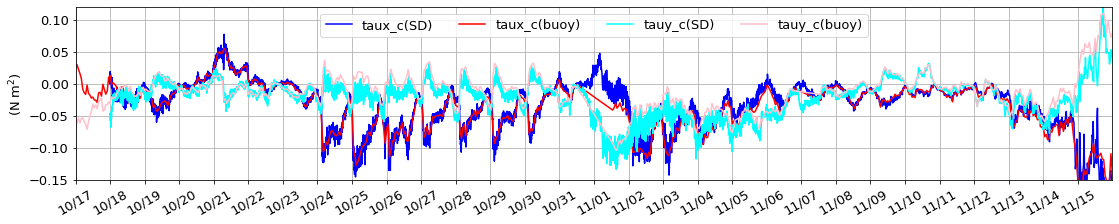

In [32]:
### plot the linearly interpolated wind and current (on current's grids)
###
platforms = ['SD','buoy']
var_str = [['taux_c','tauy_c']]
var_unit = ['(N m$^2$)']
col_in1 = [['blue','red'],['cyan','pink']]
### 
nrow = len(var_str)
plt.clf()
plt.gcf().set_size_inches(18, 3)
plt.rcParams.update({'font.size': 13})
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    for v in range( len(var_str[i]) ):
        exec_str1 = 'var1 = '+var_str[i][v]+'_'+platforms[0]+'_grid'
        exec_str2 = 'var2 = '+var_str[i][v]+'_'+platforms[1]+'_grid'
        if ('cur' in var_str[i][v]):# & ('spd' not in var_str[i][v]):
            exec_str1 = exec_str1+'[it_'+platforms[0]+',iz_'+platforms[0]+']'
            exec_str2 = exec_str2+'[it_'+platforms[1]+',iz_'+platforms[1]+']'
        exec(exec_str1)
        exec(exec_str2)
        plt.plot(eval('dtime_cur_'+platforms[0]), var1,color=col_in1[v][0],label=var_str[i][v]+'('+platforms[0]+')')
        plt.plot(eval('dtime_cur_'+platforms[1]), var2,color=col_in1[v][1],label=var_str[i][v]+'('+platforms[1]+')')
    plt.legend(ncol=4,loc='best')
    if isinstance(var_unit[i],str):
        plt.ylabel(var_unit[i])
    else:
        plt.ylabel('\n'.join(var_unit[i]))
    ### figure settings
    plt.xticks(tticks,rotation=30)
    plt.gca().set_xticklabels(tticks_label)
    plt.xlim(tlim_plot)
    plt.ylim([-0.15,0.12])
    plt.grid()
    
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.4)
### save to figure
# plt.savefig('timeseries_wind_tau_c_cur(QC)_spd_'+platf_num+'({:.1f}m)'.format(depths_cur_SD[iz_SD])+'_vs_buoy'+buoy_id+'({:.1f}m)'.format(depths_cur_buoy[iz_buoy])+'_'+\
#             tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'_on-buoy-cur-grid.png',dpi=400,bbox_inches='tight')

(6154,) (6154,) 0


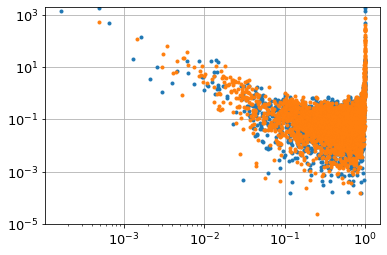

In [ ]:
### try compute & plot rotary spectra of wind stress and velocity
print(taux_c_SD_grid.shape, dtime_cur_SD.shape, np.sum(np.isnan(taux_c_SD_grid)))
cw, ccw, puv, _, F = spec_rot( taux_c_SD_grid, tauy_c_SD_grid )

plt.loglog(F,cw,'.')
plt.plot(F,ccw,'.')
plt.ylim([1e-5,2e3])
plt.grid()

'''
From https://github.com/jonathanlilly/jLab/blob/master/jSpectral/Contents.m
use jLab/jSpectral/sleptap.m for tapers
use jLab/jSpectral/mspec.m to compute rotary and cross-spectra and
jLab/jSpectral/twospecplot.m to plot
'''